In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Compare

In [2]:
import Data_prep
def print_stats(df):
    user_ratings = df.groupby('user')['rating'].count()
    item_ratings = df.groupby('item')['rating'].count()
    norpu = user_ratings.mean()
    norpi = item_ratings.mean()
    total_users = df.user.unique().size
    total_items = df.item.unique().size
    sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
    BATCH_SIZE = 64
    val_perc = test_perc = 0.1
    n_last_items_val = n_last_items_test = 1
    total_users, total_items, train_set, val_set, test_set = \
    Data_prep.train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items_val, n_last_items_test)
    
    print('rows ', len(df), 
          '\n#ratings/user', round(norpu,2), 
          '\n#ratings/item', round(norpi,2), 
          '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
          '\n#users ', df['user'].unique().size, 
          '\n#items ', df['item'].unique().size, 
          '\nsparse ', round(sparseness,5))

In [16]:
def show_results(metrics, file_name, plot_title, legend_names, path=''):
    ranks_at = metrics[0]['rank_at']
    
    figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    figure.suptitle(plot_title)
    figure.subplots_adjust(wspace=0.4, hspace=0.4)
        
    bar_width = 1.0
    bar_dist = 1.0
    line_width = 2
    title_size = 'large'
    
    #Plots
    for i, m in enumerate(metrics):
        axes[0,0].plot(ranks_at, m['recall'], linewidth=line_width)
        axes[0,1].plot(ranks_at, m['precision'], linewidth=line_width)
        axes[1,0].bar(ranks_at[1:] + i*bar_dist, m['hitcounts'][1:], width=bar_width, align='center')
        axes[1,1].bar(ranks_at[0] + i*bar_dist, m['hitcounts'][0], width=bar_width, align='center')

    # Decoration
    ## Recall@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['recall'][i] for m in metrics])
        axes[0,0].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,0].set_title('Recall@1-20', fontsize=title_size)
    axes[0,0].set_xlabel('Rank@')
    axes[0,0].set_ylabel('Recall')
    
    ## Precision@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['precision'][i] for m in metrics])
        axes[0,1].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,1].set_title('Precision@1-20', fontsize=title_size)
    axes[0,1].set_xlabel('Rank@')
    axes[0,1].set_ylabel('Precision')
     
    ## Hitcounts@5-20
    axes[1,0].set_title('Hitcounts@5-20', fontsize=title_size)
    axes[1,0].set_xlabel('Rank@')
    axes[1,0].set_ylabel('Hitcounts')
    axes[1,0].set_xlim([1,24])
    axes[1,0].set_xticks(ranks_at[1:])
    
    ## Hitcounts@1
    axes[1,1].set_title('Hitcounts@1', fontsize=title_size)
    axes[1,1].set_xlabel('Rank@1')
    axes[1,1].set_ylabel('Hitcounts')
    axes[1,1].set_xticks([])
    
    figure.legend(legend_names, loc='lower center', ncol=4, fontsize='large')
    
    if len(store_path) > 0:
        figure.savefig(path + file_name + '_results')
    plt.show()

## Init

In [17]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

In [18]:
names_am = ['Amazon_01_users']
names_ml = ['ML_01_users', 'ML_01_users']
extensions = ['', '', '_rate_above_3']

res_path = path + 'Results/Results_17_04/'
# store_path = path + 'Plots/CFRNN_plots/'
file_names = names_am + names_ml
data_paths = ['Data/Amazon/']*len(names_am) + ['Data/ML/']*len(names_ml)
plot_titles = ['Amazon 10%', 'MovieLens 10%', 'MovieLens 10% rate above 3']

In [19]:
legend_names = ['BPR', 'Random', 'Popularity']

## Plot 

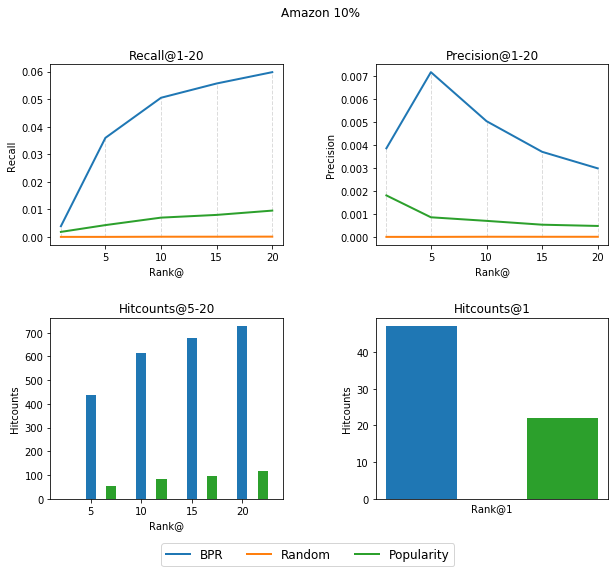

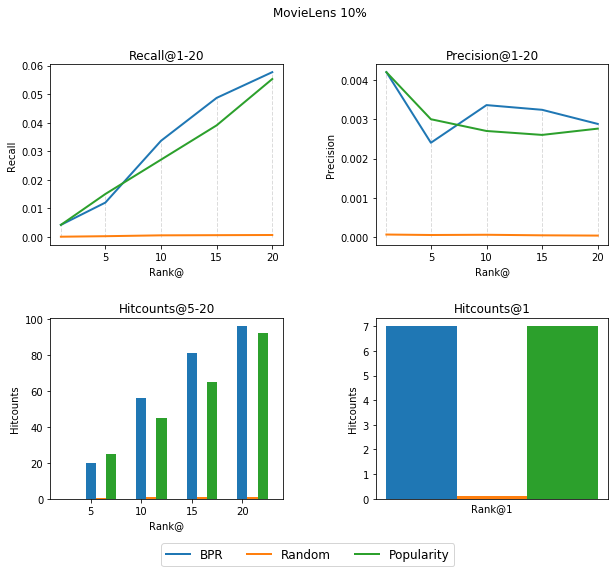

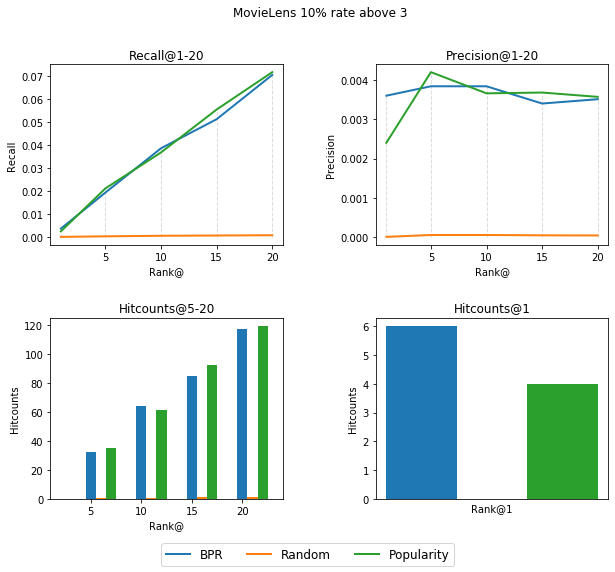

In [20]:
for file_name, data_path, ext, title in zip(file_names, data_paths, extensions, plot_titles):
    df = pd.read_pickle(path + data_path + file_name)
    print_stats(df)
    
    bpr = pd.read_pickle(res_path + 'metrics_bpr_' + file_name + ext)
    rand = pd.read_pickle(res_path + 'rand_bench_' + file_name + ext)
    pop = pd.read_pickle(res_path + 'pop_bench_' + file_name + ext)
    
    all_metrics = [bpr, rand, pop]
    show_results(all_metrics, file_name, title, legend_names, path=store_path)

# Grid Search Plots

In [23]:
def plot_grid_search(n_iterations, regs, nolfs, sample_percs, ext, metric='recall'):
    all_metrics = dict()
    for n_iters in n_iterations:
        for reg in regs:
            for nolf in nolfs:
                for sample_perc in sample_percs:
                    # Result name
                    final_name = ext + '_' + str(n_iters) + '_' + str(nolf) + '_' + str(reg) + '_' + str(sample_perc)
                    
                    # Read
                    all_metrics[reg] = pd.read_pickle(path + 'Results/BPR/Grid_Search/metrics_' + final_name)

    import matplotlib.colors as c
    diff_colors = list(c.BASE_COLORS.keys())
    for reg, col in zip(regs, diff_colors):
        plt.plot(all_metrics[0]['rank_at'], all_metrics[reg][metric], c=col)

    plt.title('Regularisation Performance')
    plt.xlabel('Rank At')
    plt.ylabel(metric)
    plt.legend(regs, bbox_to_anchor=(1.05, 1))
    plt.show()

## Amazon

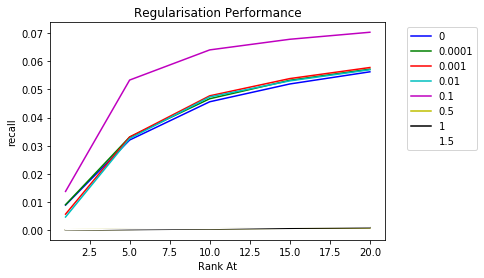

In [24]:
file_name = 'Amazon_01_users'
file_path = path + 'Data/Amazon/'
ext = 'Am'

n_iterations = [40]
regs = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5]
nolfs = [20]
sample_percs = [0.4]

plot_grid_search(n_iterations, regs, nolfs, sample_percs, ext, 'recall')

## MovieLens

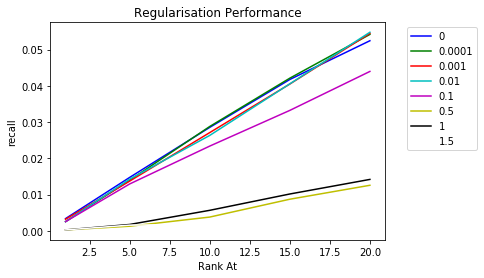

In [25]:
file_name = 'ML_01_users'
file_path = path + 'Data/ML/'
ext = 'ML'

n_iterations = [40]
regs = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5]
nolfs = [20]
sample_percs = [0.1]

plot_grid_search(n_iterations, regs, nolfs, sample_percs, ext, 'recall')

# Full data stats

In [1]:
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

In [147]:
df_amazon = pd.read_pickle(path + '/Data/Amazon/Amazon_full')

In [148]:
df_ml = pd.read_pickle(path + '/Data/ML/ML_full')

In [152]:
print_stats(df_amazon)

rows  10592657 
#ratings/user 8.73 
#ratings/item 28.22 
average rating 4.28 
#users  1213729 
#items  375397 
sparse  0.99998


In [153]:
print_stats(df_ml)

rows  25000095 
#ratings/user 153.81 
#ratings/item 423.39 
average rating 3.53 
#users  162541 
#items  59047 
sparse  0.9974
